**Title:**<br> 
Predicting Total Play Length from Player and Session Characteristics using Regression

**Introduction:**<br>
Ever wonder what kind of data could be gathered from playing video games? This was done by Frank Wood from UBC, who led a research group with the department of computer science to gather data about how video games are played. With this, they had set up a Minecraft server to record player actions as data, of which could be used in a variety of different scenarios by individuals from all sorts of professions and industries. In particular, some individuals in the gaming industry could make use of this particular type of data. Especially if they want to improve and optimize playing time on their games, one such question they may ask is such that:<br>

Can we predict a player's total play time based off of their demographic and individual session characteristics? <br>

To answer this, we must first take a look at the datasets themselves. There are two datasets that we have analyzed for this project, "players.csv" and "sessions.csv". In the players dataset, there are a total of 196 unique observations, while the sessions dataset has 1535 observations recorded. The reason for this discrepancyis that each unique player can have multiple different sessions, which are recorded in the sessions dataset. <br>

The players dataset has 7 different variables:<br>
- experience (their level of proficiency at Minecraft)
- subscribe (whether they are subscribed to the newsletter)
- hashedEmail (their email connected to their Minecraft account)
- played_hours (The total amount of hours they have spent on the game)
- name (the player's name)
- gender (the player's gender)
- Age (how old the player is)
<br>

The sessions dataset has 5 different variables:<br>
- hashedEmail (the same email connected to their account)
- start_time (readable starting time)
- end_time (readable ending time)
- original_start_time (starting time)
- original_end_time (ending time)
<br>

In this project, we have chosen 5 variables to predict the total amount of play time for a player. This includes:<br>
- The total number sessions played (minutes)
- The average length of each session (minutes)
- Age
- Experience
- Subscription
<br>

As you can see, two of the variables are related to session characteristics, while the other three are related to the individual player's demographic.

**Methods & Results:**<br>
First things first, we need to first load the libraries necessary for this project. In this case, it is tidyverse and tidymodels.

In [15]:
library(tidyverse)
library(tidymodels)

Next, we read the datasets from their csv files. We used relative file paths here from the "data" folder. <br><br>
Here we also wrangled the sessions data frame a little bit too, calculating the session times from the start and end times, while also getting rid of the original start and end times.<br><br>
Then we displayed a little bit of both the players and sessions data frames to see what we are working with here.

In [13]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv") |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time), session_length_minutes = as.numeric(end_time - start_time)) |>
    select(-original_start_time, -original_end_time)

head(players)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,session_length_minutes
<chr>,<dttm>,<dttm>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,122


For the next step, we performed further wrangling to create the necessary variables for regression later on.<br><br>
We group the hashed emails together so we have the sessions from each player together, then counted them to find the total number of sessions (sessions_num). Along with this, we found the average session length by calculating the average all the session lengths (average_session_length). Lastly, we calculated the total time played by adding together all the sessions lengths (total_play_length).<br><br>
We displayed this data frame to see the edits made.


In [3]:
sessions_summary <- sessions |>
    group_by(hashedEmail) |>
    summarise(sessions_num = n(), 
              average_session_length = mean(session_length_minutes), 
              total_play_length = sum(session_length_minutes))

head(sessions_summary)

hashedEmail,sessions_num,average_session_length,total_play_length
<chr>,<int>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,53.00000,106
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,30.00000,30
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,11.00000,11
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,32.15385,418
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,35.00000,70
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1,10.00000,10


Here, we used the "merge" function to combine the players and summarised sessions datasets together, matching the observations with their hashed emails.<br><br>
Next, we convered the subscribe and experience variables to factors, while also getting rid of all the unneccesary variables that won't be used for analyse. This leaves us with experience, subscribe, session numbers, average session length, total play time, and age. <br><br>
The reason we got rid of the old total play time was because it was measured in hours, while also being slightly inaccurate.

In [4]:
players_sessions <- merge(players, sessions_summary, by = "hashedEmail") |>
    mutate(subscribe = as.factor(subscribe), 
           experience = as.factor(experience),
           age = Age) |>
    select(-played_hours, -Age, -gender, -hashedEmail, -name)

           
head(players_sessions)

,experience,subscribe,sessions_num,average_session_length,total_play_length,age
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
1,Regular,TRUE,2,53.00000,106,20
2,Pro,FALSE,1,30.00000,30,21
3,Beginner,TRUE,1,11.00000,11,17
4,Regular,TRUE,13,32.15385,418,17
5,Pro,TRUE,2,35.00000,70,17
6,Veteran,FALSE,1,10.00000,10,19


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


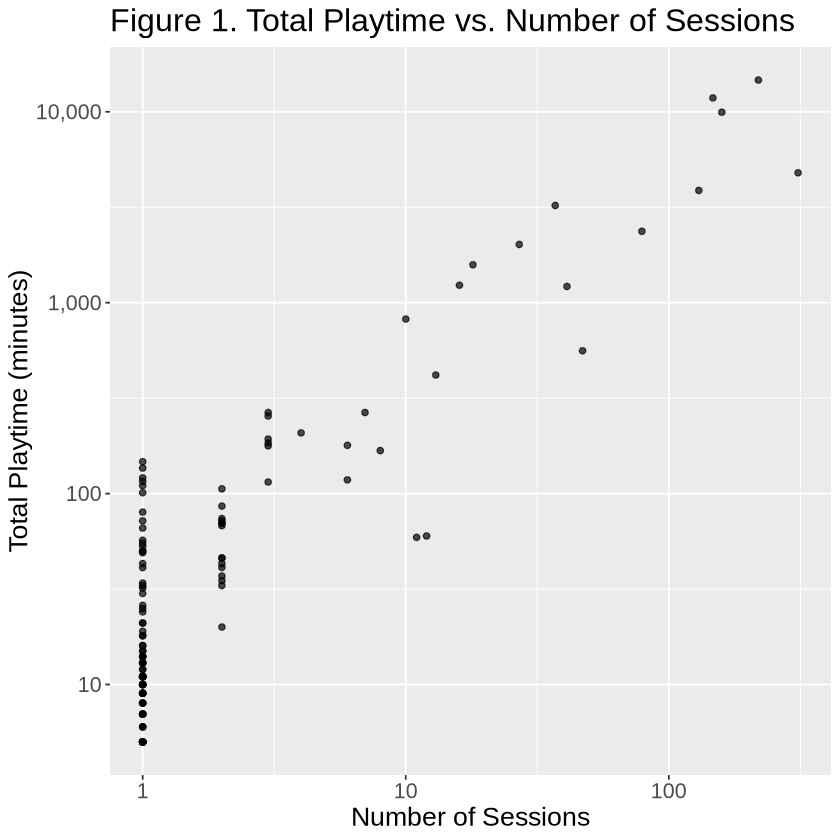

In [5]:
quick_point <- players_sessions |>
    ggplot(aes(x = sessions_num, y = total_play_length)) +
    geom_point(alpha = 0.7) +
    labs(
    title = "Figure 1. Total Playtime vs. Number of Sessions",
    x = "Number of Sessions",
    y = "Total Playtime (minutes)") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 16))

quick_point

In [6]:
set.seed(0)
data_split <- initial_split(players_sessions, prop = 0.75, strata = total_play_length)
training <- training(data_split)
testing  <- testing(data_split)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(total_play_length ~ sessions_num + average_session_length + age + experience + subscribe, data = training)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
           (Intercept)            sessions_num  average_session_length  
               -260.63                   39.08                   13.41  
                   age      experienceBeginner           experiencePro  
                -17.34                   94.50                   37.31  
     experienceRegular       experienceVeteran           subscribeTRUE  
                910.95                  236.87                   41.47  


In [7]:
lm_rmse <- lm_fit |>
        predict(training) |>
        bind_cols(training) |>
        metrics(truth = total_play_length, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()
lm_rmse

[1] 1179.652

In [8]:
lm_rmspe <- lm_fit |>
        predict(testing) |>
        bind_cols(testing) |>
        metrics(truth = total_play_length, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()
lm_rmspe

[1] 519.9123

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_recipe <- recipe(total_play_length ~ sessions_num + average_session_length + age + experience + subscribe, data = training) |>
    step_scale(all_numeric_predictors()) |> 
    step_center(all_numeric_predictors())

vfold <- vfold_cv(training, v = 5, strata = total_play_length)

gridvals <- tibble(neighbors = seq(1, 20))

knn_multi <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))

best_k <- knn_multi |>
    pull(neighbors)
best_k

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 19 rows.
               ✖ Assigned data has 20 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 20 to size 19.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 16 rows.
               ✖ Assigned data has 18 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 18 to size 16.

There were issues with some computations   A: x1
There were issues with some computations   A: x2   B: x1





[1] 3

In [10]:
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("regression")

knn_multi_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec_new) |>
  fit(data = training)

knn_multi_preds <- knn_multi_fit |>
  predict(testing) |>
  bind_cols(testing)

knn_rmspe <- metrics(knn_multi_preds, truth = total_play_length, estimate = .pred) |>
                     filter(.metric == 'rmse')

knn_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,398.6805
